# Steven's Question: Does title length affect rating? Does this change over the years?

First we import our main libraries and open all those .csv files as DataFrames.

In [1]:
import numpy as np
import pandas as pd
from glob import glob
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# This pulls all the .csv files into one list of dataframes.

csv_files = glob('zippedData/*.csv.gz')
csv_dfs = [pd.read_csv(f) for f in csv_files]
len(csv_dfs)

9

Now we give those files readable names and open them to see what meaningful columns we want to work with.

In [3]:
# Assign the .csv files to human-readable variables.
imdb_basics = csv_dfs[3]
imdb_ratings = csv_dfs[6]

In [4]:
imdb_basics.head() # Using: tconst, primary_title, start_year

,tconst,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


In [5]:
imdb_ratings.head() #Using: tconst, averagerating, numvotes

,tconst,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21


Then, we create a SQL database, check that it's in our working directory, and import our DataFrames into SQL.

In [6]:
# Create a SQL database for easy joins.

conn = sqlite3.connect('steven2.db')
cur = conn.cursor()

In [7]:
# Check to make sure SQL database was created.

In [8]:
ls

 Volume in drive C is OS
 Volume Serial Number is C084-E836

 Directory of C:\Users\Steven\class\mod1\movie-analysis

06/16/2020  02:41 PM    <DIR>          .
06/16/2020  02:41 PM    <DIR>          ..
06/16/2020  11:59 AM             2,131 .gitignore
06/16/2020  12:20 PM    <DIR>          .ipynb_checkpoints
06/16/2020  10:26 AM                16 README.md
06/16/2020  11:49 AM            61,933 steven_data_exploration.ipynb
06/16/2020  02:41 PM            34,674 steven_group_q_profit_runtime_cleaning.ipynb
06/16/2020  02:41 PM           108,120 steven_personal_avgrating_titlelength_time.ipynb
06/16/2020  11:49 AM            44,815 steven_personal_q_cleaning.ipynb
06/16/2020  12:15 PM        12,980,224 steven2.db
06/16/2020  11:59 AM    <DIR>          zippedData
               7 File(s)     13,231,913 bytes
               4 Dir(s)  42,766,860,288 bytes free


In [9]:
# Turn dataframes into tables on database.

imdb_basics.to_sql('basics', conn, if_exists='replace', index=False)
imdb_ratings.to_sql('ratings', conn, if_exists='replace', index=False)

In [10]:
# Commit database changes

conn.commit()

In [11]:
a = pd.DataFrame(cur.execute("""SELECT b.primary_title, b.start_year, b.tconst, r.numvotes, r.averagerating
                                FROM basics b
                                JOIN ratings r
                                USING(tconst)""").fetchall())
a.columns = [x[0] for x in cur.description]
basic_rating = a.set_index('tconst')
basic_rating

,primary_title,start_year,numvotes,averagerating
tconst,,,,
tt0063540,Sunghursh,2013,77,7.0
tt0066787,One Day Before the Rainy Season,2019,43,7.2
tt0069049,The Other Side of the Wind,2018,4517,6.9
tt0069204,Sabse Bada Sukh,2018,13,6.1
tt0100275,The Wandering Soap Opera,2017,119,6.5
...,...,...,...,...
tt9913084,Diabolik sono io,2019,6,6.2
tt9914286,Sokagin Çocuklari,2019,136,8.7
tt9914642,Albatross,2017,8,8.5


Above, we've joined the two DataFrames we were interested in. I did in this in SQL as opposed to Pandas' built-in methods simply cause I'm more comfortable using it.

Now, we're going refine this DataFrame a bit more. We don't want data from movies with too few votes, so let's drop anything with less than 100 and see where that leaves us.

In [12]:
# We pass the DataFrame a Pandas series of booleans.
# True values have 100+ votes and are kept.

enough_votes = basic_rating.numvotes >= 100
br2 = basic_rating[enough_votes]
br2.head()

,primary_title,start_year,numvotes,averagerating
tconst,,,,
tt0069049,The Other Side of the Wind,2018,4517,6.9
tt0100275,The Wandering Soap Opera,2017,119,6.5
tt0137204,Joe Finds Grace,2017,263,8.1
tt0146592,Pál Adrienn,2010,451,6.8
tt0162942,Children of the Green Dragon,2010,120,6.9


Great! We still have a lot of data to work with, and have gotten rid of anything where there's not enough ratings to really be salient. But now we need to add a new column for title length. We'll be looking at number of words as opposed to number of letters. (This decision was made because the English syllabary is awfully messy and inconsistent in its average length. For example, a single syllable word can be as short as "a" or as long as "strength." For this reason, whole words are a more reliable metric.)

In [13]:
# Make an empty list to hold title lengths.
# Make another list, that contains all the split titles in our DataFrame.
# Use a for loop to populate the first list with the word-lengths of these titles.

title_lengths = []
split_titles = br2['primary_title'].str.split()
for i in range(0,28753):
    title_lengths.append(len(split_titles[i]))

In [14]:
# Check that it works

title_lengths[:5]

[6, 4, 3, 2, 5]

In [21]:
# Create a new column using our title length list

br2.loc[:,'title_length'] = title_lengths
br2

,primary_title,start_year,numvotes,averagerating,title_length
tconst,,,,,
tt0069049,The Other Side of the Wind,2018,4517,6.9,6
tt0100275,The Wandering Soap Opera,2017,119,6.5,4
tt0137204,Joe Finds Grace,2017,263,8.1,3
tt0146592,Pál Adrienn,2010,451,6.8,2
tt0162942,Children of the Green Dragon,2010,120,6.9,5
...,...,...,...,...,...
tt9904844,Ott Tänak: The Movie,2019,218,8.7,4
tt9905412,Ottam,2019,505,8.1,1
tt9905462,Pengalila,2019,600,8.4,1


Sweet, looks good! Our data is cleaned and ready to be plotted.

# Plotting The Data: Length, Rating, And Release Year

In [16]:
br2['title_length'].unique()

array([ 6,  4,  3,  2,  5,  1,  7, 11,  8, 10,  9, 14, 12, 13, 15, 16],
      dtype=int64)

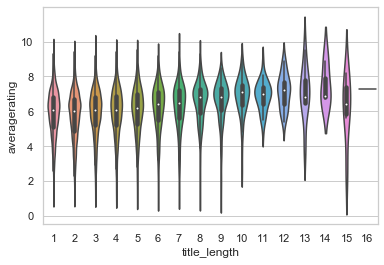

In [17]:
sns.set(style="whitegrid", palette="bright")

# Draw a nested violinplot and split the violins for easier comparison
sns.violinplot(x=br2['title_length'], y=br2['averagerating'])
sns;

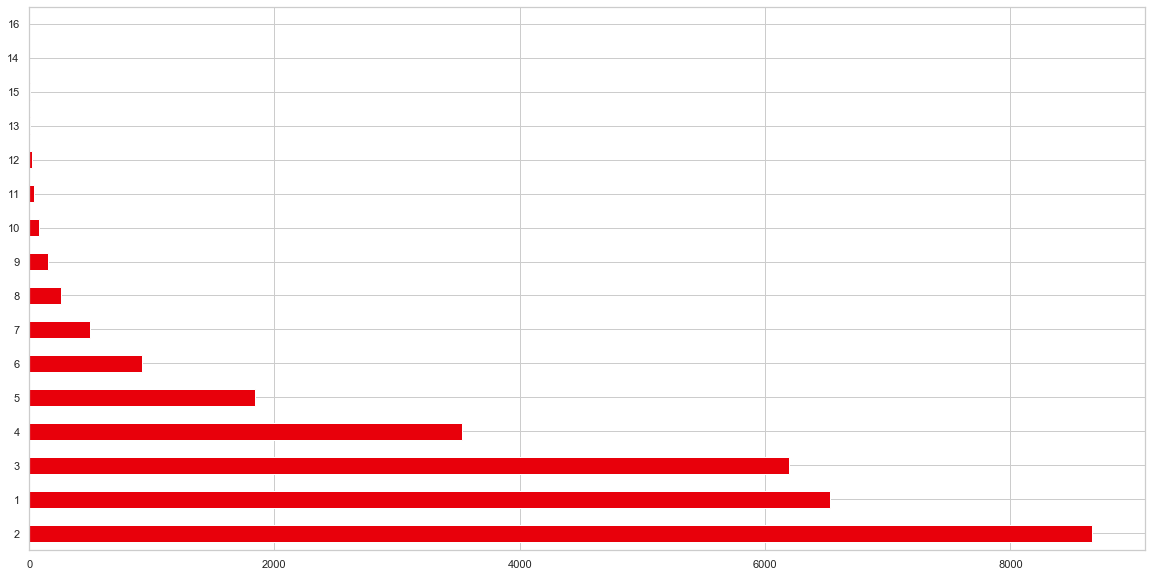

In [18]:
br2['title_length'].value_counts().plot(kind='barh', figsize=(20,10), color='r');

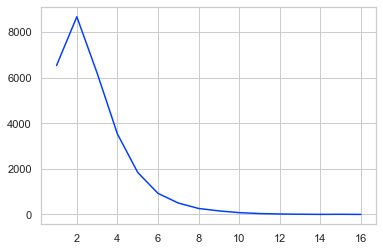

In [19]:
plt.plot(br2['title_length'].value_counts().sort_index());

In [20]:
longboyz = br2.title_length >= 14
br2[longboyz]

,primary_title,start_year,numvotes,averagerating,title_length
tconst,,,,,
tt1641808,Bruce Springsteen and the E Street Band: Londo...,2010,241,8.9,14
tt2084868,Kamen Rider Movie War Mega Max: Kamen Rider vs...,2011,119,6.9,14
tt2417650,30 Nights of Paranormal Activity with the Devi...,2013,3381,2.6,15
tt2480784,Which Way Is the Front Line from Here? The Lif...,2013,628,7.8,15
tt2916786,Jeff Wayne's Musical Version of the War of the...,2013,198,7.3,16
tt3329956,Eu Não Faço a Menor Ideia do Que Eu Tô Fazendo...,2012,373,5.6,15
tt4881172,The Sky Trembles and the Earth Is Afraid and t...,2015,198,6.1,15
tt5246328,How to Let Go of the World and Love All the Th...,2016,327,7.0,15
tt5338774,Power of Grayskull: The Definitive History of ...,2017,753,6.7,14
